<h2>Manga Searching Recommender System</h2>

---

<details>
  <summary><h3 style="color: #EFD1B4;" id="table_content">Nội dung</h3></summary>

  - Cài đặt thư viện
  - Tải và hiểu dữ liệu
  - Kỹ thuật xử lý đặc trưng
  - Xây dựng mô hình
</details>

<h2 style="color: #EFD1B4;" id="libraries_importing">Cài đặt thư viện</h2>

---

Chúng tôi sử dụng các thư viện phổ biến trong Python như pandas để xử lý và phân tích dữ liệu, scikit-learn để xây dựng và huấn luyện các mô hình học máy, và imblearn để xử lý các vấn đề mất cân bằng dữ liệu.


Ngoài ra, chúng tôi sử dụng thư viện `cosine_similarity` để tính toán độ tương đồng giữa các manga.

Để xử lý văn bản, chúng tôi sử dụng `TfidfVectorizer` để biến các cột văn bản thành các vector số.

Cuối cùng, đối với các cột số, chúng tôi sử dụng `MinMaxScaler` để chuẩn hóa giá trị của chúng.


In [1]:
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse as sp
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns


<h2 style="color: #EFD1B4;" id="load_and_understand_data">Tải và hiểu dữ liệu</h2>

---


Để tái sử dụng và mở rộng trong tương lai, chúng tôi đóng gói các đường dẫn liên quan vào `BIẾN HẰNG`.

In [2]:
ANIME_DATA = r'..\Preprocessing\Preprocessed Data\Manga\manga_processed.csv'
ANIME_DATA = os.path.abspath(ANIME_DATA)
print(ANIME_DATA)

d:\Data Science Introduction\Final_Project\Preprocessing\Preprocessed Data\Manga\manga_processed.csv


In [3]:
df = pd.read_csv(ANIME_DATA)
df.head()

,Title,Score,Vote,Ranked,Popularity,Members,Favorite,Types,Volumes,Chapters,...,Genres,Demographic,Serialization,Author,Released date,Completed date,Total Review,Recommended,Mixed Feelings,Not Recommended
0,Berserk,9.47,363720,1,1,725079,130489,Manga,3,16,...,"[""'Action'"", ""'Adventure'"", ""'Award Winning'"",...",Seinen,Young Animal,"[""'Miura,Kentarou'"", ""'Studio Gaga'""]",1989-08-25,Updating,289,252,17,20
1,JoJo no Kimyou na Bouken Part 7: Steel Ball Ru...,9.31,172219,2,23,280428,46269,Manga,24,96,...,"[""'Action'"", ""'Adventure'"", ""'Mystery'"", ""'Sup...",Seinen,Ultra Jump,"[""'Araki,Hirohiko'""]",2004-01-19,2011-04-19,131,123,7,1
2,Vagabond,9.26,154583,3,13,406082,44258,Manga,37,327,...,"[""'Action'"", ""'Adventure'"", ""'Award Winning'"",...",Seinen,Morning,"[""'Inoue,Takehiko'"", ""'Yoshikawa,Eiji'""]",1998-09-03,2015-05-21,104,93,9,2
3,One Piece,9.22,392811,4,4,642620,119974,Manga,3,16,...,"[""'Action'"", ""'Adventure'"", ""'Fantasy'""]",Shounen,Shounen Jump (Weekly),"[""'Oda,Eiichiro'""]",1997-07-22,Updating,231,190,21,20
4,Monster,9.16,104327,5,29,258581,22008,Manga,18,162,...,"[""'Award Winning'"", ""'Drama'"", ""'Mystery'"", ""'...",Seinen,Big Comic Original,"[""'Urasawa,Naoki'""]",1994-12-05,2001-12-20,86,69,11,6


Các thuộc tính của tập dữ liệu

In [4]:
df.keys()

Index(['Title', 'Score', 'Vote', 'Ranked', 'Popularity', 'Members', 'Favorite',
       'Types', 'Volumes', 'Chapters', 'Status', 'Genres', 'Demographic',
       'Serialization', 'Author', 'Released date', 'Completed date',
       'Total Review', 'Recommended', 'Mixed Feelings', 'Not Recommended'],
      dtype='object')

In [5]:
df.isnull().sum()

Title                 0
Score                 0
Vote                  0
Ranked                0
Popularity            0
Members               0
Favorite              0
Types                 0
Volumes               0
Chapters              0
Status                0
Genres                0
Demographic        8006
Serialization      2922
Author                0
Released date         0
Completed date        0
Total Review          0
Recommended           0
Mixed Feelings        0
Not Recommended       0
dtype: int64

Trực quan hóa ma trận tương quan giữa các cột số

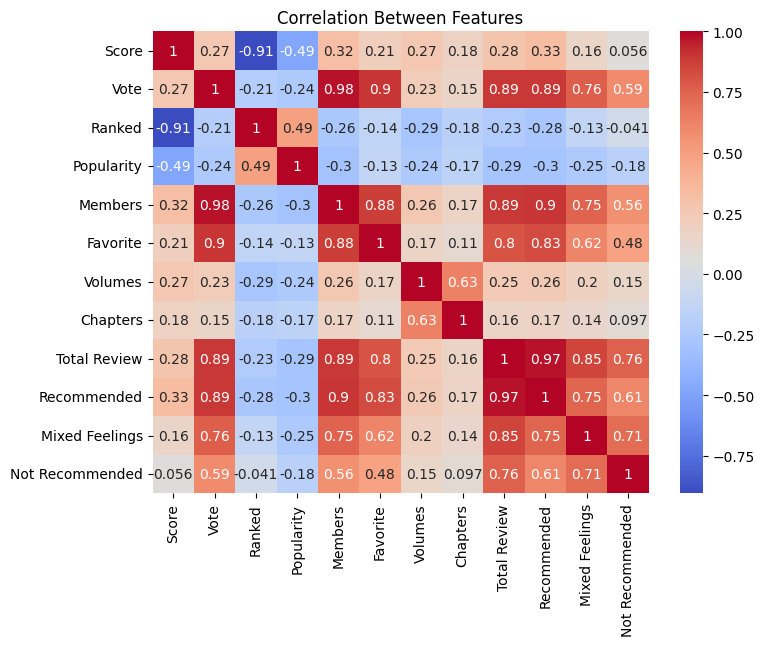

In [6]:
# Compute a correlation matrix for example (if applicable)
correlation = df.corr(numeric_only=True)

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', cbar=True)
plt.title('Correlation Between Features')
plt.show()


<h2 style="color: #EFD1B4;" id="feature_engineering">Kỹ thuật xử lí đặc trưng</h2>

---


Xử lí các cột có giá trị chuỗi

Chúng tôi chuyển đổi các thuộc tính kiểu danh sách của Genres và Author thành chuỗi văn bản. Sau đó, áp dụng các phương pháp xử lý văn bản như TF-IDF (Term Frequency - Inverse Document Frequency) vào các thuộc tính này. Các thuộc tính này có thể chứa các danh sách giá trị được phân tách bằng dấu phẩy (,), và chúng cần được chuyển đổi thành một chuỗi đơn để có thể sử dụng trong mô hình học máy.

In [7]:
# Chuyển các thuộc tính dạng list thành chuỗi văn bản
df['Genres_str'] = df['Genres'].apply(lambda x: " ".join([genre.strip("'") for genre in x.split(',')]) if x and isinstance(x, str) else "")
df['Author_str'] = df['Author'].apply(lambda x: " ".join([author.strip("'") for author in x.split(',')]) if x and isinstance(x, str) else "")

# Áp dụng TF-IDF cho các thuộc tính dạng chuỗi
tfidf = TfidfVectorizer(stop_words='english')

tfidf_Title_matrix = tfidf.fit_transform(df['Title'])
tfidf_Types_matrix = tfidf.fit_transform(df['Types'])
tfidf_Genres_matrix = tfidf.fit_transform(df['Genres_str'])
tfidf_Author_matrix = tfidf.fit_transform(df['Author_str'])

Chuẩn hóa các cột dạng số

In [8]:

# Chuẩn hóa các thuộc tính dạng số
scaler = MinMaxScaler()
df[['Score', 'Vote', 'Ranked', 'Popularity', 'Recommended']] = scaler.fit_transform(df[['Score', 'Vote', 'Ranked', 'Popularity', 'Recommended']])


Tiếp theo, chúng tôi kết hợp nhiều ma trận thưa (sparse matrices) (chứa các đặc trưng văn bản đã được chuyển đổi bằng phương pháp TF-IDF) với dữ liệu số (chẳng hạn như Score, Vote, v.v.) từ một pandas DataFrame (df) thành một ma trận thưa duy nhất. Ma trận thưa kết hợp này (X_tfidf) sẵn sàng được sử dụng trong mô hình, đồng thời duy trì hiệu quả trong việc sử dụng bộ nhớ và tính toán.

In [9]:
X_tfidf = sp.hstack([
    tfidf_Title_matrix, 
    tfidf_Types_matrix,
    tfidf_Genres_matrix,
    tfidf_Author_matrix,
    sp.csr_matrix(df[['Score']].values),  # Chuyển các cột số sang sparse
    sp.csr_matrix(df[['Vote']].values),
    sp.csr_matrix(df[['Ranked']].values),
    sp.csr_matrix(df[['Popularity']].values),
    sp.csr_matrix(df[['Recommended']].values)
])


In [10]:
# Tính ma trận độ tương đồng cosine
cosine_sim = cosine_similarity(X_tfidf, X_tfidf)


<h2 style="color: #EFD1B4;" id="build_model">Xây dựng mô hình</h2>

---


In [11]:
def recommend_anime(title, cosine_sim, df, top_n=5):
    # Step 1: Find the index (anime_id) of the anime matching the title
    idx = df[df['Title'] == title].index

    if idx.empty:
        print(f"No anime found with title: {title}")
        return []
    
    idx = idx[0]  # Get the first match (assuming titles are unique)

    # Step 2: Get the similarity scores for this anime
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Step 3: Sort by similarity scores in descending order
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Step 4: Get the top_n most similar anime (excluding itself)
    sim_scores = sim_scores[1:top_n+1]  # Skip the first, as it’s the same anime

    # Step 5: Retrieve the anime titles for recommendations
    anime_indices = [i[0] for i in sim_scores]
    recommended = df.iloc[anime_indices]

    return recommended[['Title', 'Score']]  # Return relevant columns


In [12]:
title_to_search = "Yotsuba to! (Yotsuba&!)"
recommendations = recommend_anime(title_to_search, cosine_sim, df, top_n=5)

if not recommendations.empty:
    print("Recommended anime:")
    print(recommendations)
else:
    print("No recommendations found.")


Recommended anime:
                                            Title     Score
246                                Azumanga Daioh  0.842330
1104                   Azumanga Daioh: Hoshuu-hen  0.771307
14739                    Try! Try! Try! Webcomics  0.586648
3103          Shissou Nikki (Disappearance Diary)  0.715909
55     Shoujo Shuumatsu Ryokou (Girls' Last Tour)  0.892045
